In [339]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [340]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [341]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389309 entries, 0 to 2389308
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.5 MB


# reduce to 1 million events

In [342]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [343]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,25697,0.14,25.697
1,25758,0.14,25.758
2,25750,0.14,25.750
3,25861,0.14,25.861
4,25796,0.14,25.796
...,...,...,...
999995,24598,0.15,24.598
999996,24879,0.14,24.879
999997,24881,0.14,24.881
999998,24796,0.14,24.796


### conversion Interval -> kWh

In [344]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,25697,0.14,25.697,140.094174
1,25758,0.14,25.758,139.762404
2,25750,0.14,25.750,139.805825
3,25861,0.14,25.861,139.205754
4,25796,0.14,25.796,139.556520
...,...,...,...,...
999995,24598,0.15,24.598,146.353362
999996,24879,0.14,24.879,144.700350
999997,24881,0.14,24.881,144.688718
999998,24796,0.14,24.796,145.184707


### Cumul Total interval

In [345]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [346]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27095265351000

### Calcul de la date de base = now - cumul_interval

In [347]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 3, 6, 50, 35, 640563)

In [348]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [349]:
conso_data.iloc[0]


Interval     25697.000000
kWh              0.140000
sec             25.697000
Wh             140.094174
cumul(ms)    25697.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [350]:
base

datetime.datetime(2024, 9, 3, 6, 50, 35, 640563)

## créer les dates

In [351]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-03 06:51:01.337563
1        2024-09-03 06:51:27.095563
2        2024-09-03 06:51:52.845563
3        2024-09-03 06:52:18.706563
4        2024-09-03 06:52:44.502563
                    ...            
999995   2025-07-13 21:16:41.575563
999996   2025-07-13 21:17:06.454563
999997   2025-07-13 21:17:31.335563
999998   2025-07-13 21:17:56.131563
999999   2025-07-13 21:18:20.991563
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [352]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,25697,0.14,25.697,140.094174,25697,2024-09-03 06:51:01.337563,03/09/24
1,25758,0.14,25.758,139.762404,51455,2024-09-03 06:51:27.095563,03/09/24
2,25750,0.14,25.750,139.805825,77205,2024-09-03 06:51:52.845563,03/09/24
3,25861,0.14,25.861,139.205754,103066,2024-09-03 06:52:18.706563,03/09/24
4,25796,0.14,25.796,139.556520,128862,2024-09-03 06:52:44.502563,03/09/24
...,...,...,...,...,...,...,...
999995,24598,0.15,24.598,146.353362,27095165935,2025-07-13 21:16:41.575563,13/07/25
999996,24879,0.14,24.879,144.700350,27095190814,2025-07-13 21:17:06.454563,13/07/25
999997,24881,0.14,24.881,144.688718,27095215695,2025-07-13 21:17:31.335563,13/07/25
999998,24796,0.14,24.796,145.184707,27095240491,2025-07-13 21:17:56.131563,13/07/25


### save conso_data with dates

In [353]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [354]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('13/07/25', 13, 7, 2025, '21:18:45')

In [355]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [356]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, 997652 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2348 non-null   int64         
 1   kWh        2348 non-null   float64       
 2   sec        2348 non-null   float64       
 3   Wh         2348 non-null   float64       
 4   cumul(ms)  2348 non-null   int64         
 5   dates      2348 non-null   datetime64[ns]
 6   days       2348 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 146.8+ KB


In [357]:
end = time.time()
print(end - start)

31.355158805847168


### grouped by days

In [358]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [359]:
data = list(df_grp['kWh'])
print(data)

[2.388, 4.13, 3.529, 3.658, 3.602, 3.156, 2.615, 1.799, 1.792, 1.795, 1.794, 2.414, 1.924, 1.787, 1.793, 1.788, 1.819, 1.82, 1.818, 1.814, 1.818, 1.817, 1.815, 1.818, 1.784, 1.788, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.793, 1.801, 1.798, 1.799, 1.801, 1.785, 1.787, 1.788, 1.788, 1.798, 1.791, 1.799, 1.804, 1.793, 1.802, 1.798, 2.645, 3.999, 3.679, 3.897, 3.091, 3.358, 4.132, 3.358, 3.504, 3.99, 3.324, 3.732, 3.577, 3.973, 3.203, 3.317, 3.397, 4.094, 3.282, 3.389, 3.821, 3.226, 3.542, 3.293, 3.914, 3.351, 3.422, 3.752, 4.411, 3.605, 3.854, 3.374, 4.219, 3.498, 3.446, 3.285, 3.86, 3.687, 4.117, 3.212, 3.729, 3.807, 3.156, 3.684, 3.656, 3.384, 3.88, 3.19, 4.065, 3.448, 3.707, 4.069, 3.413, 4.529, 3.264, 3.466, 3.108, 3.219, 3.431, 3.351, 3.419, 3.429, 4.606, 4.544, 3.227, 3.455, 3.634, 3.934, 3.544, 4.457, 4.179, 4.089, 3.776, 3.737, 3.548, 3.537, 4.386, 3.165, 3.382, 3.4, 3.447, 3.611, 3.379, 4.557, 3.258, 3.786, 3.249, 3.603, 3.543, 3.288, 3.995, 3.276, 4.687, 3.927, 3.312, 

In [360]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [361]:
end = time.time()
print(end - start)

32.31507134437561


### plot function by day
#### show('dd/mm/yy')

In [362]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


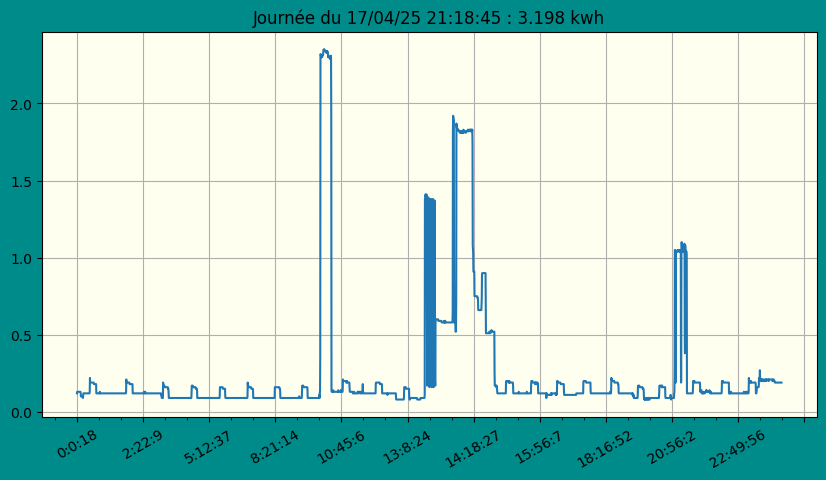

In [363]:
show('17/04/25')

In [364]:
end = time.time()
print(end - start)

34.280597448349


### 1 kWh window in data of one day
#### df = conso_day

In [365]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997652,29157,0.12,29.157,123.469493,27018586160,2025-07-13 00:00:21.800563,13/07/25
997653,29154,0.12,29.154,123.482198,27018615314,2025-07-13 00:00:50.954563,13/07/25
997654,29217,0.12,29.217,123.215936,27018644531,2025-07-13 00:01:20.171563,13/07/25
997655,28465,0.13,28.465,126.471105,27018672996,2025-07-13 00:01:48.636563,13/07/25
997656,22576,0.16,22.576,159.461375,27018695572,2025-07-13 00:02:11.212563,13/07/25
...,...,...,...,...,...,...,...
999995,24598,0.15,24.598,146.353362,27095165935,2025-07-13 21:16:41.575563,13/07/25
999996,24879,0.14,24.879,144.700350,27095190814,2025-07-13 21:17:06.454563,13/07/25
999997,24881,0.14,24.881,144.688718,27095215695,2025-07-13 21:17:31.335563,13/07/25
999998,24796,0.14,24.796,145.184707,27095240491,2025-07-13 21:17:56.131563,13/07/25


In [366]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [367]:
df = conso_day
len(df)

2348

In [368]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-13 00:00:21.800563	2025-07-13 08:48:25.482563	8h 48m 3s 	1000
2025-07-13 08:48:25.482563	2025-07-13 17:49:16.289563	9h 0m 50s 	2000


In [369]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.300426
dtype: float64

In [370]:
end = time.time()
print(end - start)

34.68038535118103


## mean for data grouped by days

In [371]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.184713
dtype: float64

In [372]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.348)

# conso by date


In [373]:
# select day
day = today

#day = '16/08/24'
day

'13/07/25'

In [374]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997652,29157,0.12,29.157,123.469493,27018586160,2025-07-13 00:00:21.800563,13/07/25
997653,29154,0.12,29.154,123.482198,27018615314,2025-07-13 00:00:50.954563,13/07/25
997654,29217,0.12,29.217,123.215936,27018644531,2025-07-13 00:01:20.171563,13/07/25
997655,28465,0.13,28.465,126.471105,27018672996,2025-07-13 00:01:48.636563,13/07/25
997656,22576,0.16,22.576,159.461375,27018695572,2025-07-13 00:02:11.212563,13/07/25
...,...,...,...,...,...,...,...
999995,24598,0.15,24.598,146.353362,27095165935,2025-07-13 21:16:41.575563,13/07/25
999996,24879,0.14,24.879,144.700350,27095190814,2025-07-13 21:17:06.454563,13/07/25
999997,24881,0.14,24.881,144.688718,27095215695,2025-07-13 21:17:31.335563,13/07/25
999998,24796,0.14,24.796,145.184707,27095240491,2025-07-13 21:17:56.131563,13/07/25


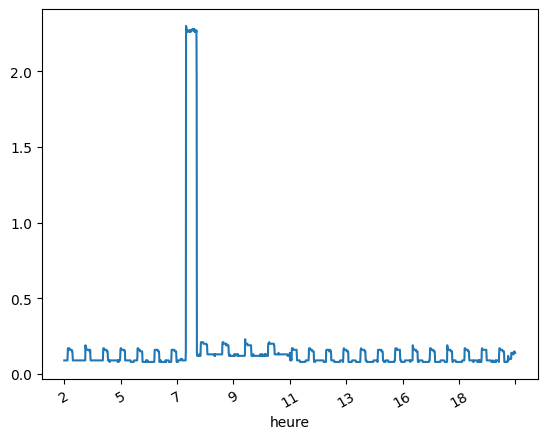

In [375]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [376]:
end = time.time()
print(end - start)

35.56998324394226


### grouped by 'heure'

In [377]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, 997652 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2348 non-null   int64         
 1   kWh        2348 non-null   float64       
 2   sec        2348 non-null   float64       
 3   Wh         2348 non-null   float64       
 4   cumul(ms)  2348 non-null   int64         
 5   dates      2348 non-null   datetime64[ns]
 6   days       2348 non-null   object        
 7   heure      2348 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 165.1+ KB


In [378]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997652,29157,0.12,29.157,123.469493,27018586160,2025-07-13 00:00:21.800563,13/07/25
997653,29154,0.12,29.154,123.482198,27018615314,2025-07-13 00:00:50.954563,13/07/25
997654,29217,0.12,29.217,123.215936,27018644531,2025-07-13 00:01:20.171563,13/07/25
997655,28465,0.13,28.465,126.471105,27018672996,2025-07-13 00:01:48.636563,13/07/25
997656,22576,0.16,22.576,159.461375,27018695572,2025-07-13 00:02:11.212563,13/07/25
...,...,...,...,...,...,...,...
999995,24598,0.15,24.598,146.353362,27095165935,2025-07-13 21:16:41.575563,13/07/25
999996,24879,0.14,24.879,144.700350,27095190814,2025-07-13 21:17:06.454563,13/07/25
999997,24881,0.14,24.881,144.688718,27095215695,2025-07-13 21:17:31.335563,13/07/25
999998,24796,0.14,24.796,145.184707,27095240491,2025-07-13 21:17:56.131563,13/07/25


In [379]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [380]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     143
1     111
2      99
3     106
4      99
5      96
6      95
7     104
8     171
9     143
10    140
11    111
12    104
13     99
14     96
15     95
16    107
17     96
18     95
19    102
20    100
21     36
Name: kWh, dtype: int64

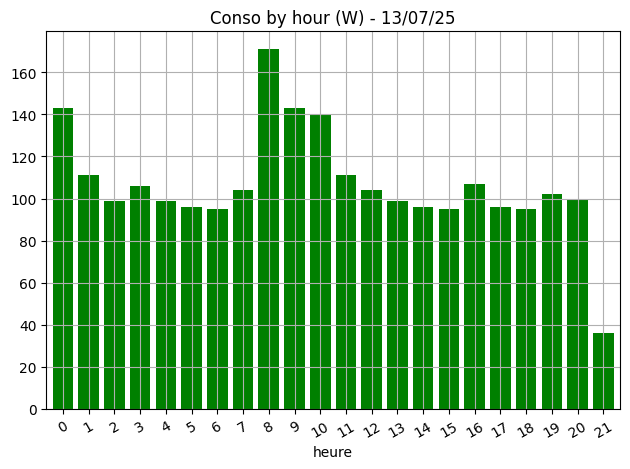

In [381]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [382]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 03/09/24 to 13/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     314 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [383]:
# give the periods of 1 kwh in a day
period()

2025-07-13 00:00:21.800563	2025-07-13 08:48:25.482563	8h 48m 3s 	1000


In [384]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [385]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [386]:
df_grp.mean()


kWh    3.184713
dtype: float64

In [387]:
df_grp.head()


,kWh
days,
03/09/24,2.388
04/09/24,4.130
05/09/24,3.529
06/09/24,3.658
07/09/24,3.602


In [388]:
df_grp.tail()


,kWh
days,
09/07/25,3.951
10/07/25,2.938
11/07/25,2.679
12/07/25,2.600
13/07/25,2.348


In [389]:
end = time.time()
print(end - start)

37.950581073760986


# plot les 100 derniers jours


In [390]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    2.99873
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

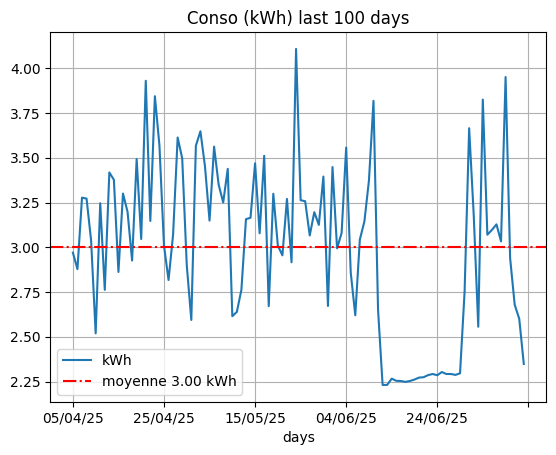

In [391]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [392]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.231
max,4.108


In [393]:
end = time.time()
print(end - start)

38.688164710998535


In [394]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('13/06/25', '08/07/25')

In [395]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.637367
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

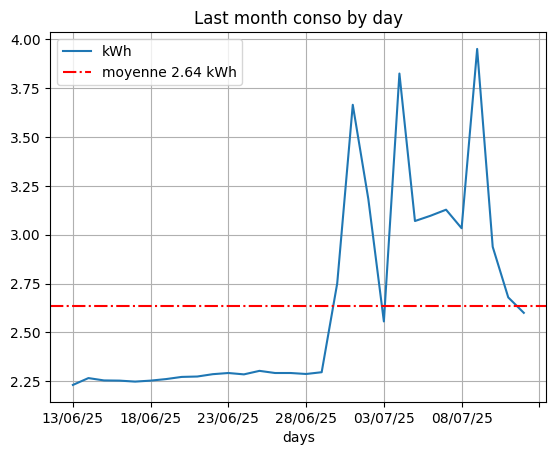

In [396]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [397]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/07/25 3.951
Min : 13/06/25 2.231


# Temps de conso par tranche de 1 kWh

In [398]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-07-13 00:00:21.800563	2025-07-13 08:48:25.482563	8h 48m 3s 	1000
2025-07-13 08:48:25.482563	2025-07-13 17:49:16.289563	9h 0m 50s 	2000
2025-07-13 17:49:16.289563	2025-07-13 21:18:20.991563	3h 29m 4s 	348


In [399]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('21:18:45', 2.348, 2348)

In [400]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, 997652 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2348 non-null   int64         
 1   kWh        2348 non-null   float64       
 2   sec        2348 non-null   float64       
 3   Wh         2348 non-null   float64       
 4   cumul(ms)  2348 non-null   int64         
 5   dates      2348 non-null   datetime64[ns]
 6   days       2348 non-null   object        
 7   heure      2348 non-null   object        
 8   hours      2348 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 183.4+ KB


In [401]:
conso_hours['heure'], conso_hours['hours']

(997652     0
 997653     0
 997654     0
 997655     0
 997656     0
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: heure, Length: 2348, dtype: object,
 997652    00
 997653    00
 997654    00
 997655    00
 997656    00
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: hours, Length: 2348, dtype: object)

In [402]:
end = time.time()
print(end - start)

39.81951451301575


# select number of days to display


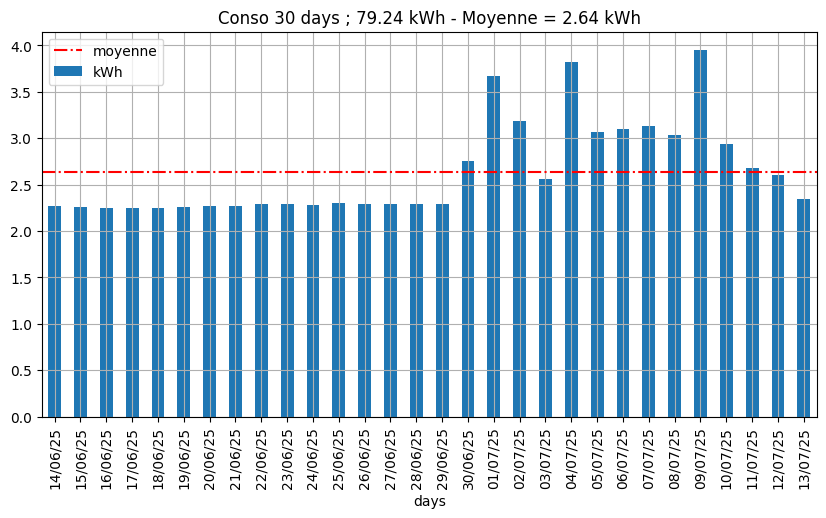

In [403]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


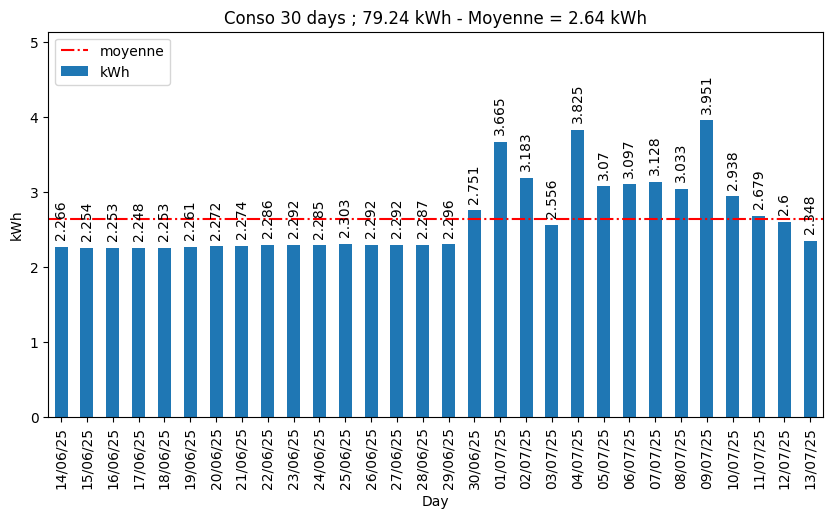

In [404]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [405]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
14/06/25    2.266
15/06/25    2.254
16/06/25    2.253
17/06/25    2.248
18/06/25    2.253
19/06/25    2.261
20/06/25    2.272
21/06/25    2.274
22/06/25    2.286
23/06/25    2.292
24/06/25    2.285
25/06/25    2.303
26/06/25    2.292
27/06/25    2.292
28/06/25    2.287
29/06/25    2.296
30/06/25    2.751
01/07/25    3.665
02/07/25    3.183
03/07/25    2.556
04/07/25    3.825
05/07/25    3.070
06/07/25    3.097
07/07/25    3.128
08/07/25    3.033
09/07/25    3.951
10/07/25    2.938
11/07/25    2.679
12/07/25    2.600
13/07/25    2.348
Name: kWh, dtype: float64

In [406]:
x_labels=df_grp.tail(span).index
x_labels

Index(['14/06/25', '15/06/25', '16/06/25', '17/06/25', '18/06/25', '19/06/25',
       '20/06/25', '21/06/25', '22/06/25', '23/06/25', '24/06/25', '25/06/25',
       '26/06/25', '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25',
       '02/07/25', '03/07/25', '04/07/25', '05/07/25', '06/07/25', '07/07/25',
       '08/07/25', '09/07/25', '10/07/25', '11/07/25', '12/07/25', '13/07/25'],
      dtype='object', name='days')

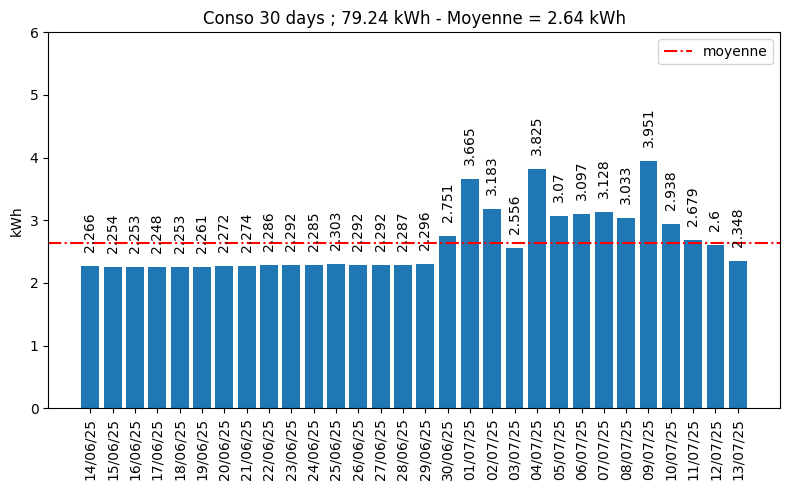

In [407]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [408]:
end = time.time()
print(end - start)

45.41689419746399


In [409]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

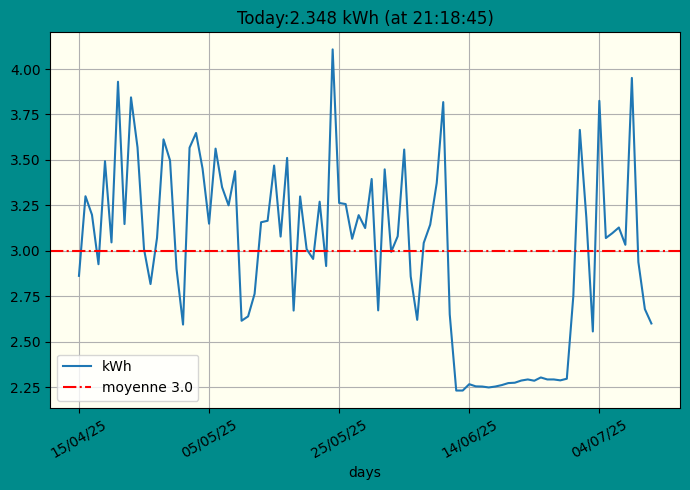

In [410]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

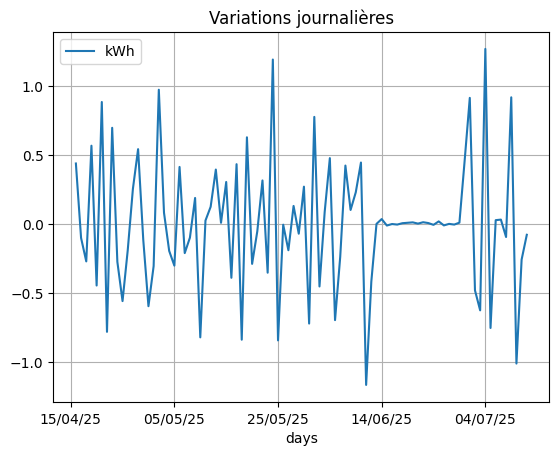

In [411]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [412]:
end = time.time()
print(end - start)

46.830078125


# Data from 21/08/23

In [413]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,25697,0.14,25.697,140.094174,25697,2024-09-03 06:51:01.337563,03/09/24,06,2024-09,03
1,25758,0.14,25.758,139.762404,51455,2024-09-03 06:51:27.095563,03/09/24,06,2024-09,03
2,25750,0.14,25.750,139.805825,77205,2024-09-03 06:51:52.845563,03/09/24,06,2024-09,03
3,25861,0.14,25.861,139.205754,103066,2024-09-03 06:52:18.706563,03/09/24,06,2024-09,03
4,25796,0.14,25.796,139.556520,128862,2024-09-03 06:52:44.502563,03/09/24,06,2024-09,03
...,...,...,...,...,...,...,...,...,...,...
999995,24598,0.15,24.598,146.353362,27095165935,2025-07-13 21:16:41.575563,13/07/25,21,2025-07,13
999996,24879,0.14,24.879,144.700350,27095190814,2025-07-13 21:17:06.454563,13/07/25,21,2025-07,13
999997,24881,0.14,24.881,144.688718,27095215695,2025-07-13 21:17:31.335563,13/07/25,21,2025-07,13
999998,24796,0.14,24.796,145.184707,27095240491,2025-07-13 21:17:56.131563,13/07/25,21,2025-07,13


In [414]:
end = time.time()
print(end - start)

95.34811854362488


In [415]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

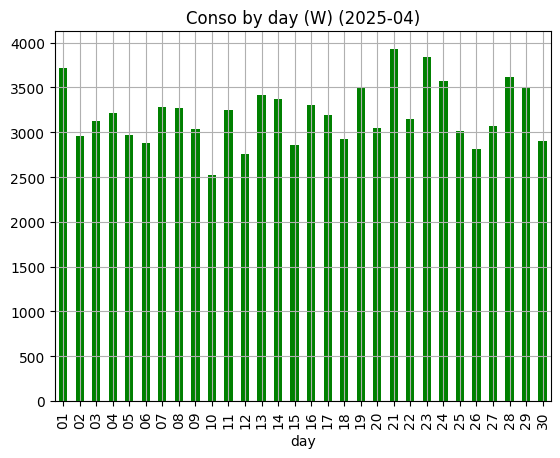

In [416]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [417]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.0333333333333)

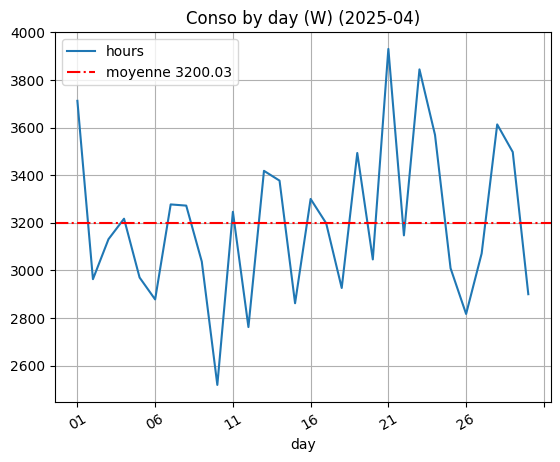

In [418]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [419]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

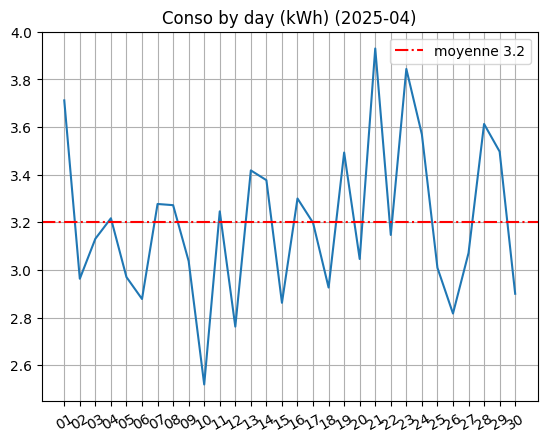

In [420]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [421]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [422]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [423]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,61644,61644,61644
2024-10,73322,73322,73322
2024-11,108177,108177,108177
2024-12,113984,113984,113984
2025-01,113873,113873,113873
2025-02,104281,104281,104281
2025-03,111823,111823,111823
2025-04,96001,96001,96001
2025-05,98609,98609,98609


In [424]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [425]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [426]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
03/09/24,2388
04/09/24,4130
05/09/24,3529
06/09/24,3658
07/09/24,3602
...,...
09/07/25,3951
10/07/25,2938
11/07/25,2679


In [427]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,25697,0.14,25.697,140.094174,25697,2024-09-03 06:51:01.337563,03/09/24,06,2024-09,03
1,25758,0.14,25.758,139.762404,51455,2024-09-03 06:51:27.095563,03/09/24,06,2024-09,03
2,25750,0.14,25.750,139.805825,77205,2024-09-03 06:51:52.845563,03/09/24,06,2024-09,03
3,25861,0.14,25.861,139.205754,103066,2024-09-03 06:52:18.706563,03/09/24,06,2024-09,03
4,25796,0.14,25.796,139.556520,128862,2024-09-03 06:52:44.502563,03/09/24,06,2024-09,03
...,...,...,...,...,...,...,...,...,...,...
999995,24598,0.15,24.598,146.353362,27095165935,2025-07-13 21:16:41.575563,13/07/25,21,2025-07,13
999996,24879,0.14,24.879,144.700350,27095190814,2025-07-13 21:17:06.454563,13/07/25,21,2025-07,13
999997,24881,0.14,24.881,144.688718,27095215695,2025-07-13 21:17:31.335563,13/07/25,21,2025-07,13
999998,24796,0.14,24.796,145.184707,27095240491,2025-07-13 21:17:56.131563,13/07/25,21,2025-07,13


In [428]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
03/09/24 06    0       03/09/24    06  0.14
               1       03/09/24    06  0.14
               2       03/09/24    06  0.14
               3       03/09/24    06  0.14
               4       03/09/24    06  0.14
...                         ...   ...   ...
13/07/25 21    999995  13/07/25    21  0.15
               999996  13/07/25    21  0.14
               999997  13/07/25    21  0.14
               999998  13/07/25    21  0.14
               999999  13/07/25    21  0.14

[1000000 rows x 3 columns]

In [429]:
groupallbyday.indices.keys()

dict_keys(['03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/1

In [430]:
groupallbydayhours.indices.keys()

dict_keys([('03/09/24', '06'), ('03/09/24', '07'), ('03/09/24', '08'), ('03/09/24', '09'), ('03/09/24', '10'), ('03/09/24', '11'), ('03/09/24', '12'), ('03/09/24', '13'), ('03/09/24', '14'), ('03/09/24', '15'), ('03/09/24', '16'), ('03/09/24', '17'), ('03/09/24', '18'), ('03/09/24', '19'), ('03/09/24', '20'), ('03/09/24', '21'), ('03/09/24', '22'), ('03/09/24', '23'), ('04/09/24', '06'), ('04/09/24', '07'), ('04/09/24', '08'), ('04/09/24', '09'), ('04/09/24', '10'), ('04/09/24', '11'), ('04/09/24', '12'), ('04/09/24', '13'), ('04/09/24', '14'), ('04/09/24', '15'), ('04/09/24', '16'), ('04/09/24', '17'), ('04/09/24', '18'), ('04/09/24', '19'), ('04/09/24', '20'), ('04/09/24', '21'), ('04/09/24', '22'), ('04/09/24', '23'), ('04/09/24', '00'), ('04/09/24', '01'), ('04/09/24', '02'), ('04/09/24', '03'), ('04/09/24', '04'), ('04/09/24', '05'), ('05/09/24', '06'), ('05/09/24', '07'), ('05/09/24', '08'), ('05/09/24', '09'), ('05/09/24', '10'), ('05/09/24', '11'), ('05/09/24', '12'), ('05/09/2

In [431]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
03/09/24,2388,2388
04/09/24,4130,4130
05/09/24,3529,3529
06/09/24,3658,3658
07/09/24,3602,3602
...,...,...
09/07/25,3951,3951
10/07/25,2938,2938
11/07/25,2679,2679


In [432]:
grp_by_day['kWh'].cumsum()

days
03/09/24       2388
04/09/24       6518
05/09/24      10047
06/09/24      13705
07/09/24      17307
             ...   
09/07/25     989435
10/07/25     992373
11/07/25     995052
12/07/25     997652
13/07/25    1000000
Name: kWh, Length: 314, dtype: int64

In [433]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
03/09/24 06      21
         07     127
         08     121
         09     122
         10     122
...             ...
13/07/25 17      96
         18      95
         19     102
         20     100
         21      36

[7528 rows x 1 columns]

In [434]:
grp_by_dayhours['kWh'].cumsum()

days      hours
03/09/24  06            21
          07           148
          08           269
          09           391
          10           513
                    ...   
13/07/25  17        999667
          18        999762
          19        999864
          20        999964
          21       1000000
Name: kWh, Length: 7528, dtype: int64

In [435]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
03/09/24 06      21      21    NaN
         07     127     148  106.0
         08     121     269   -6.0
         09     122     391    1.0
         10     122     513    0.0
...             ...     ...    ...
13/07/25 17      96    2015  -11.0
         18      95    2110   -1.0
         19     102    2212    7.0
         20     100    2312   -2.0
         21      36    2348  -64.0

[7528 rows x 3 columns]

In [436]:
today, grp_by_dayhours.loc[today]

('13/07/25',
        kWh  cumsum  diff
 hours                   
 00     143     143   NaN
 01     111     254 -32.0
 02      99     353 -12.0
 03     106     459   7.0
 04      99     558  -7.0
 05      96     654  -3.0
 06      95     749  -1.0
 07     104     853   9.0
 08     171    1024  67.0
 09     143    1167 -28.0
 10     140    1307  -3.0
 11     111    1418 -29.0
 12     104    1522  -7.0
 13      99    1621  -5.0
 14      96    1717  -3.0
 15      95    1812  -1.0
 16     107    1919  12.0
 17      96    2015 -11.0
 18      95    2110  -1.0
 19     102    2212   7.0
 20     100    2312  -2.0
 21      36    2348 -64.0)

Text(0.5, 1.0, 'Cumul journalier')

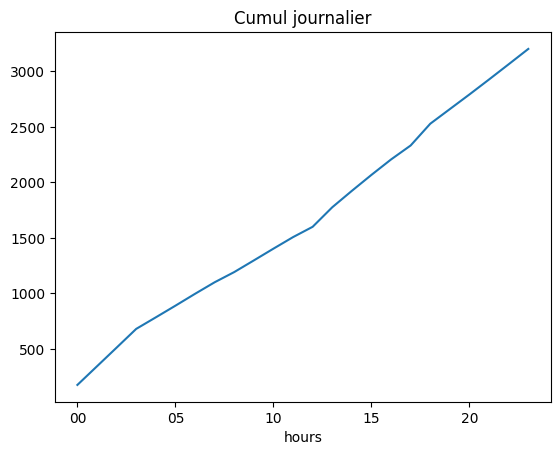

In [437]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

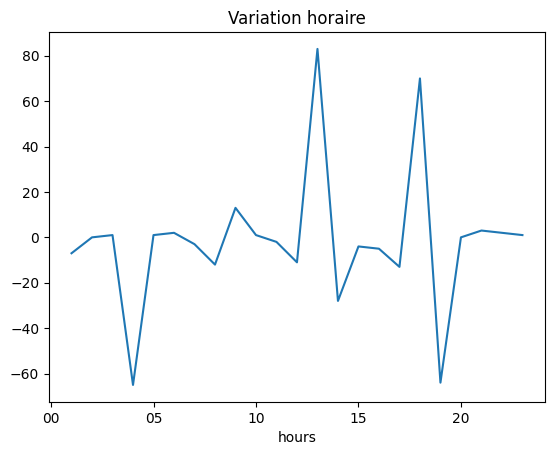

In [438]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [439]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

314

In [440]:
df_grp.tail(n)['kWh'].describe()


count    314.000000
mean       3.184713
std        0.734409
min        1.783000
25%        2.827500
50%        3.320500
75%        3.663250
max        4.788000
Name: kWh, dtype: float64

In [441]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [442]:
n, np.nanmean(df_grp.tail(n))

(314, np.float64(3.1847133757961785))

Text(0.5, 1.0, '314 days')

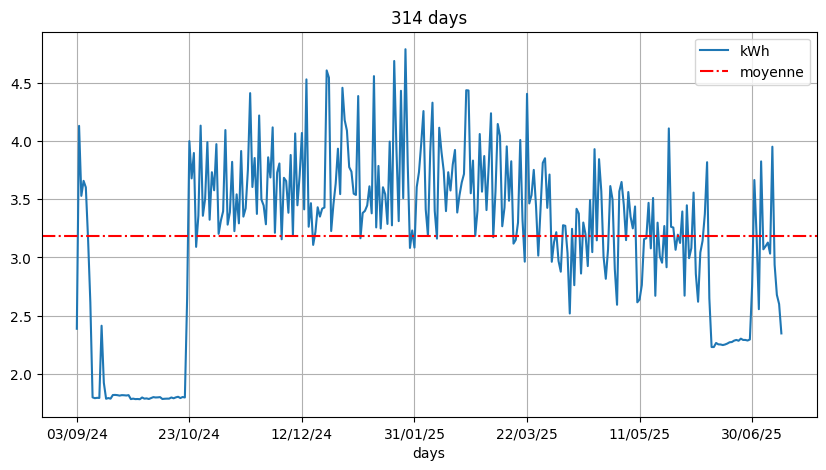

In [443]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

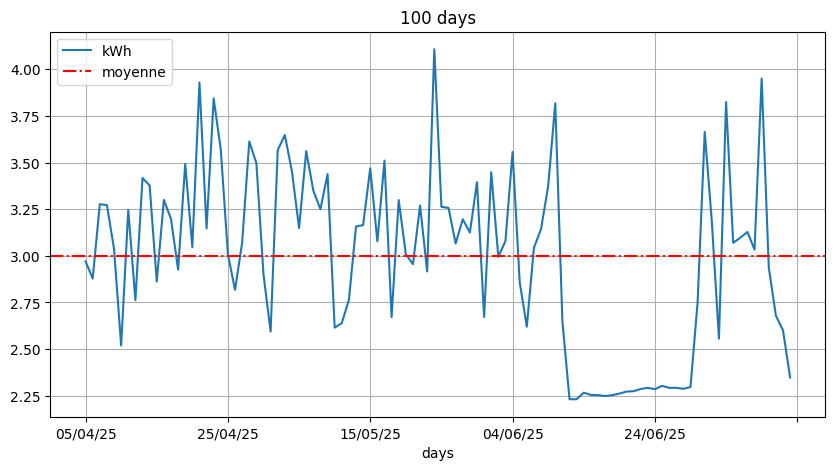

In [444]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [445]:
np.nanmean(df_grp.tail(span))

np.float64(2.99873)

In [446]:
df_grp['kWh']

days
03/09/24    2.388
04/09/24    4.130
05/09/24    3.529
06/09/24    3.658
07/09/24    3.602
            ...  
09/07/25    3.951
10/07/25    2.938
11/07/25    2.679
12/07/25    2.600
13/07/25    2.348
Name: kWh, Length: 314, dtype: float64

In [447]:
df_grp.describe()

,kWh
count,314.000000
mean,3.184713
std,0.734409
min,1.783000
25%,2.827500
50%,3.320500
75%,3.663250
max,4.788000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

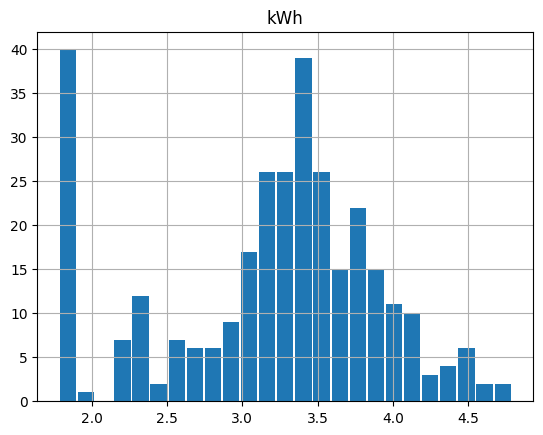

In [448]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [449]:
df_grp.tail(span)['kWh']

days
05/04/25    2.970
06/04/25    2.878
07/04/25    3.277
08/04/25    3.272
09/04/25    3.037
            ...  
09/07/25    3.951
10/07/25    2.938
11/07/25    2.679
12/07/25    2.600
13/07/25    2.348
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [450]:
day

'13/07/25'

In [451]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,143,143,NaN
01,111,254,-32.0
02,99,353,-12.0
03,106,459,7.0
04,99,558,-7.0
05,96,654,-3.0
06,95,749,-1.0
07,104,853,9.0
08,171,1024,67.0


In [452]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [453]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [454]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [455]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [456]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [457]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [458]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [459]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [460]:
day

'13/07/25'

In [461]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,143,143,NaN,1.0
01,111,254,-32.0,2.0
02,99,353,-12.0,3.0
03,106,459,7.0,4.0
04,99,558,-7.0,5.0
05,96,654,-3.0,6.0
06,95,749,-1.0,7.0
07,104,853,9.0,8.0
08,171,1024,67.0,9.0


In [462]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_3340\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(2.3480000000000003)

In [463]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
03/09/24 06      21      21    NaN   NaN
         07     127     148  106.0   NaN
         08     121     269   -6.0   NaN
         09     122     391    1.0   NaN
         10     122     513    0.0   NaN
...             ...     ...    ...   ...
13/07/25 17      96    2015  -11.0  18.0
         18      95    2110   -1.0  19.0
         19     102    2212    7.0  20.0
         20     100    2312   -2.0  21.0
         21      36    2348  -64.0  22.0

[7528 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '13/07/25: kWh    2.348\ndtype: float64')

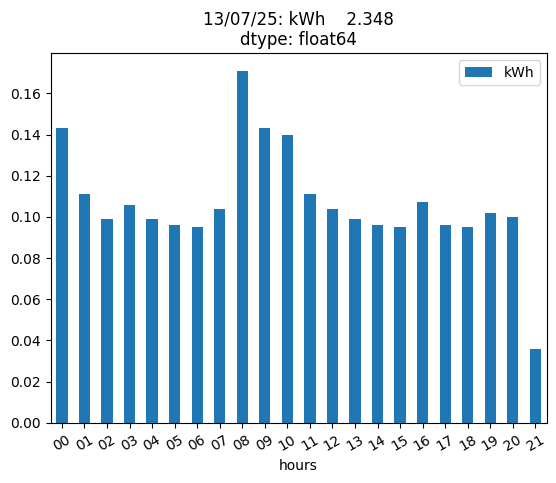

In [464]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [465]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [466]:
grp_by_dayhours.count()

kWh       7528
cumsum    7528
diff      7214
days        22
dtype: int64

'27/01/25'

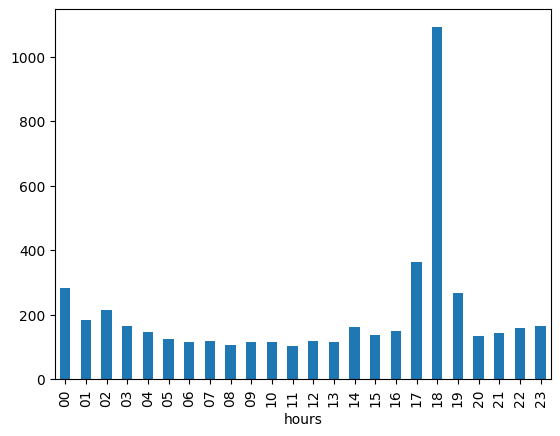

In [467]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [468]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 299.873 , Moyenne= 2.99873


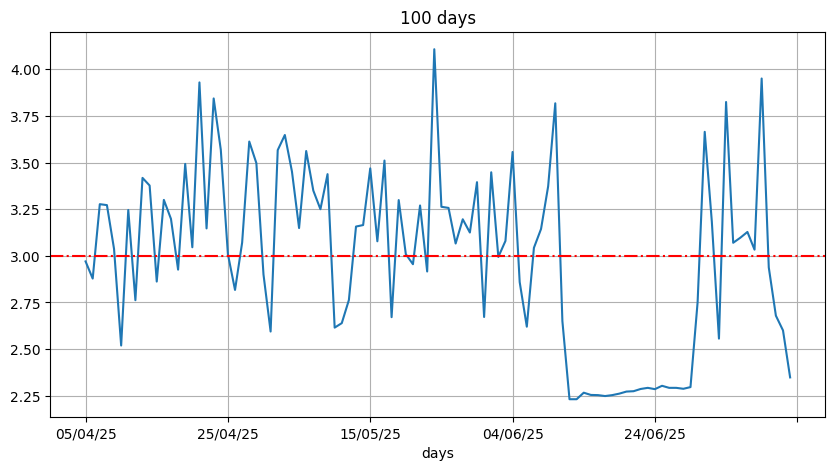

In [469]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [470]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 21:20:13, Minutes in day: 1280


In [471]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [472]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:59.43


In [473]:
end - start

119.43327283859253

In [474]:
#df = conso_day
show_tranches()

3
2025-07-13 00:00:21.800563	2025-07-13 08:48:25.482563	8h 48m 3s 	1000
2025-07-13 08:48:25.482563	2025-07-13 17:49:16.289563	9h 0m 50s 	2000
2025-07-13 17:49:16.289563	2025-07-13 21:18:20.991563	3h 29m 4s 	348


In [475]:
df_grp.tail(7)['kWh']

days
07/07/25    3.128
08/07/25    3.033
09/07/25    3.951
10/07/25    2.938
11/07/25    2.679
12/07/25    2.600
13/07/25    2.348
Name: kWh, dtype: float64

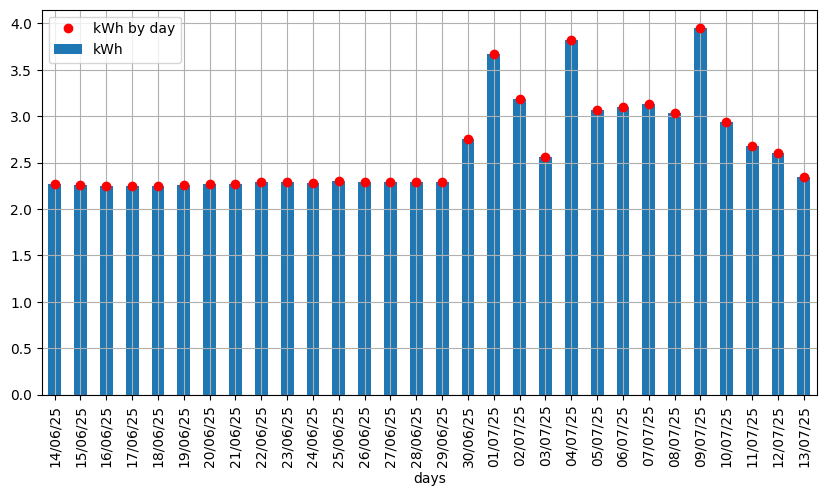

In [476]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

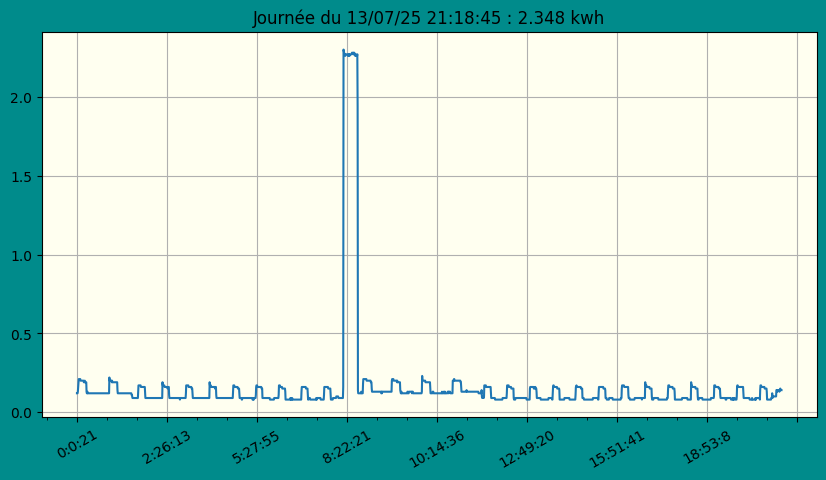

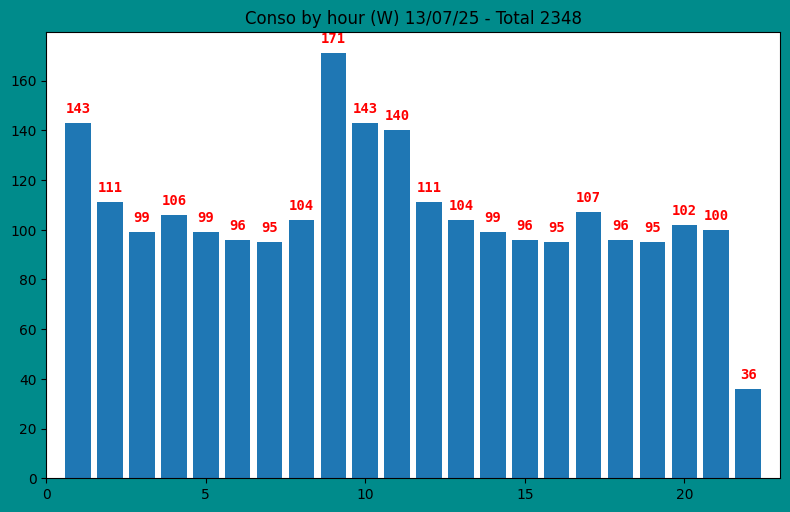

In [477]:
show(today,bgcolor='ivory')
conso_by_hour(today)

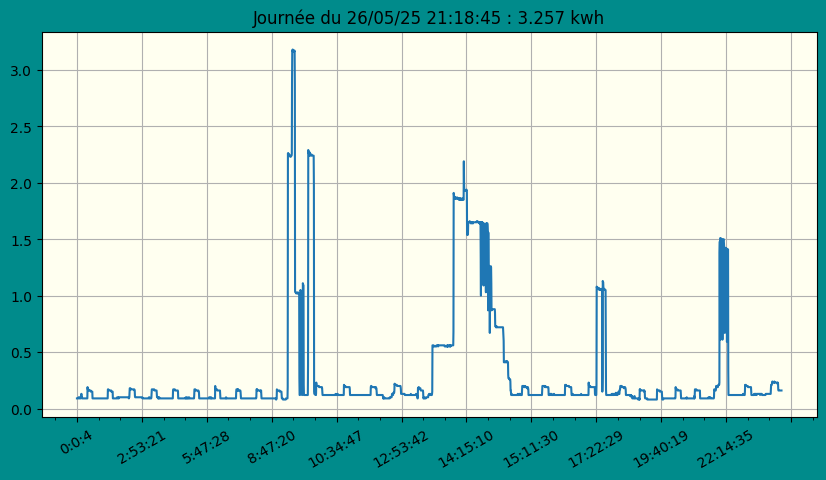

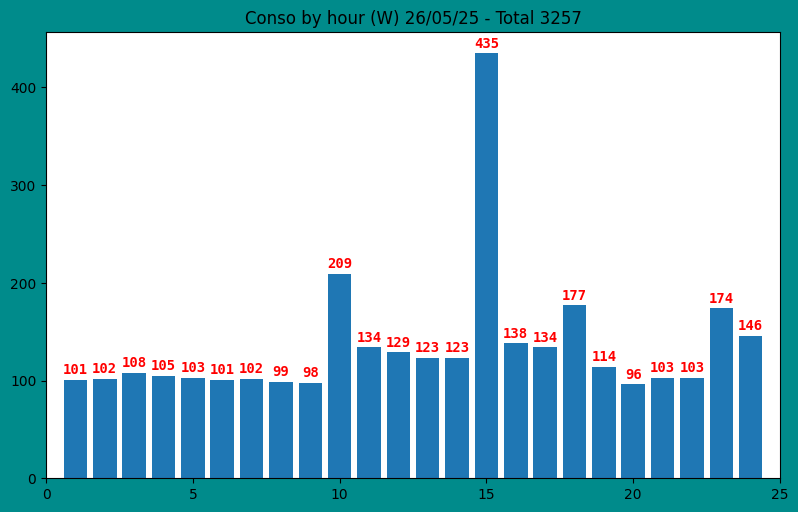

In [478]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4788)

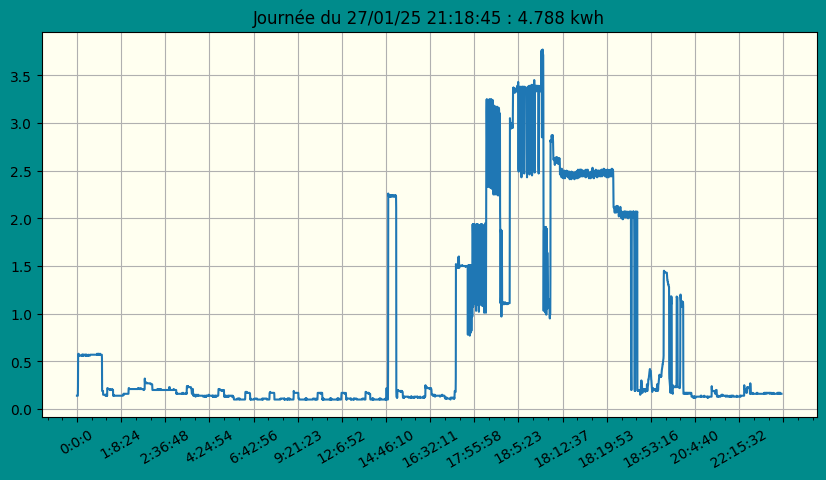

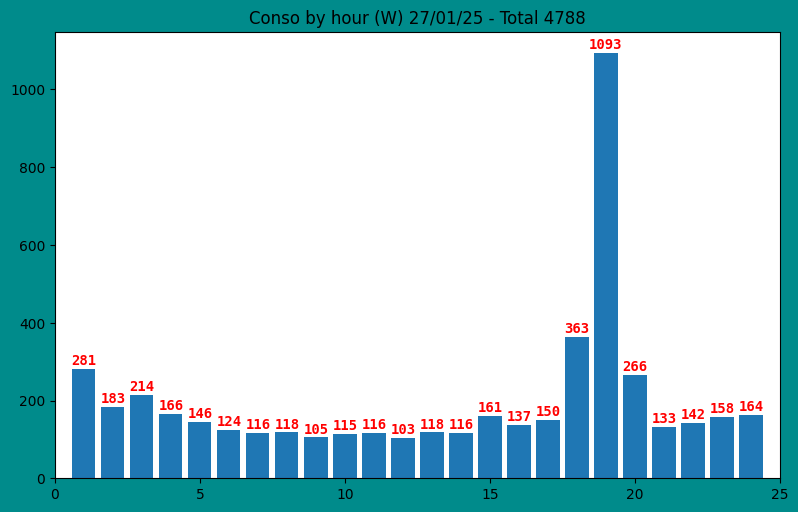

In [479]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

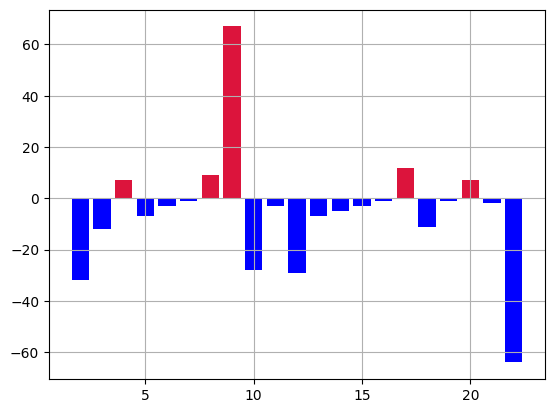

In [480]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

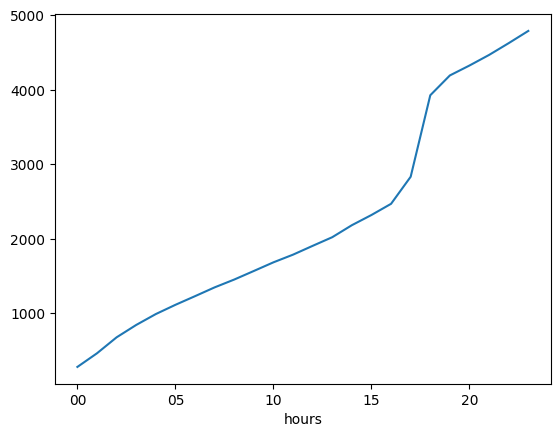

In [481]:
data.cumsum().plot()


<Axes: xlabel='hours'>

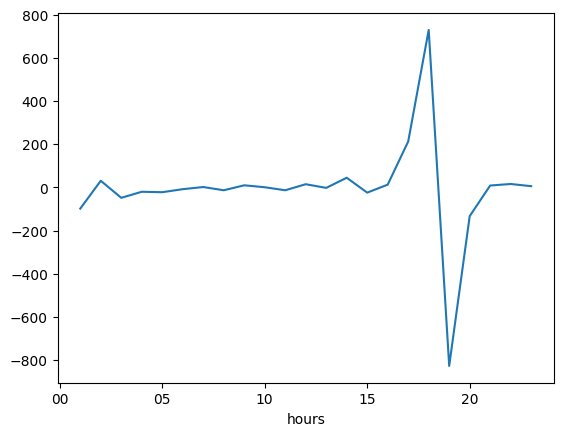

In [482]:
# evolution par heure
data.diff().plot()

In [483]:
data.diff().describe()

count     23.000000
mean      -5.086957
std      242.798441
min     -827.000000
25%      -21.000000
50%        1.000000
75%       14.000000
max      730.000000
Name: kWh, dtype: float64

<Axes: >

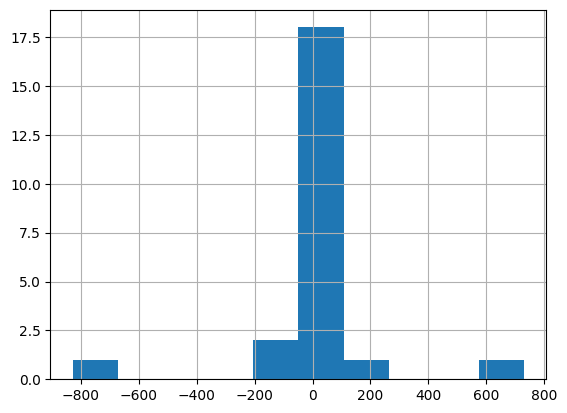

In [484]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [485]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [486]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

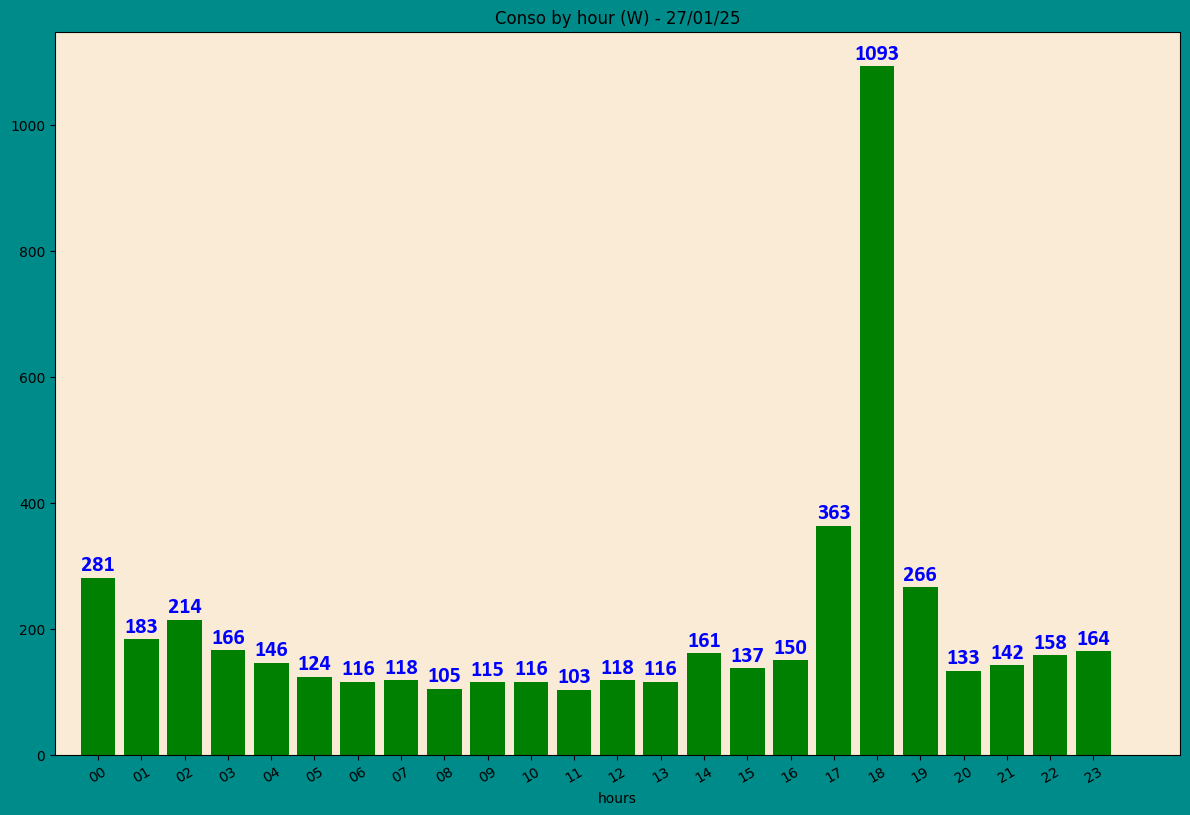

In [487]:
day,conso_byhour(day)

In [488]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


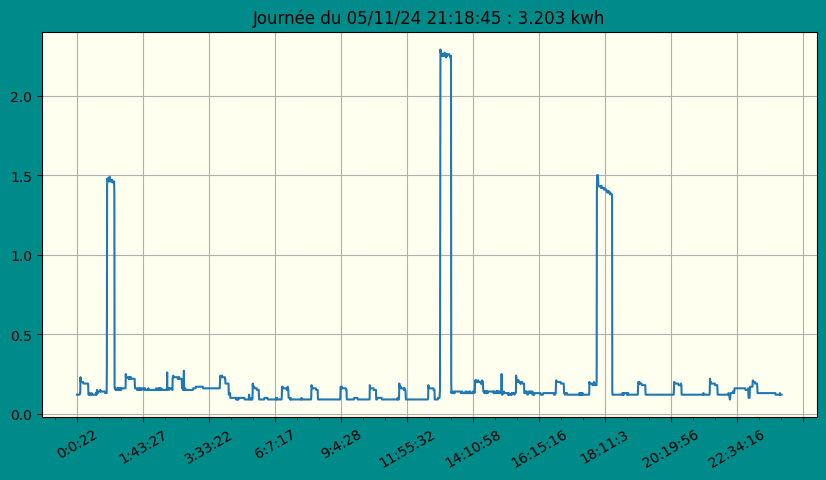

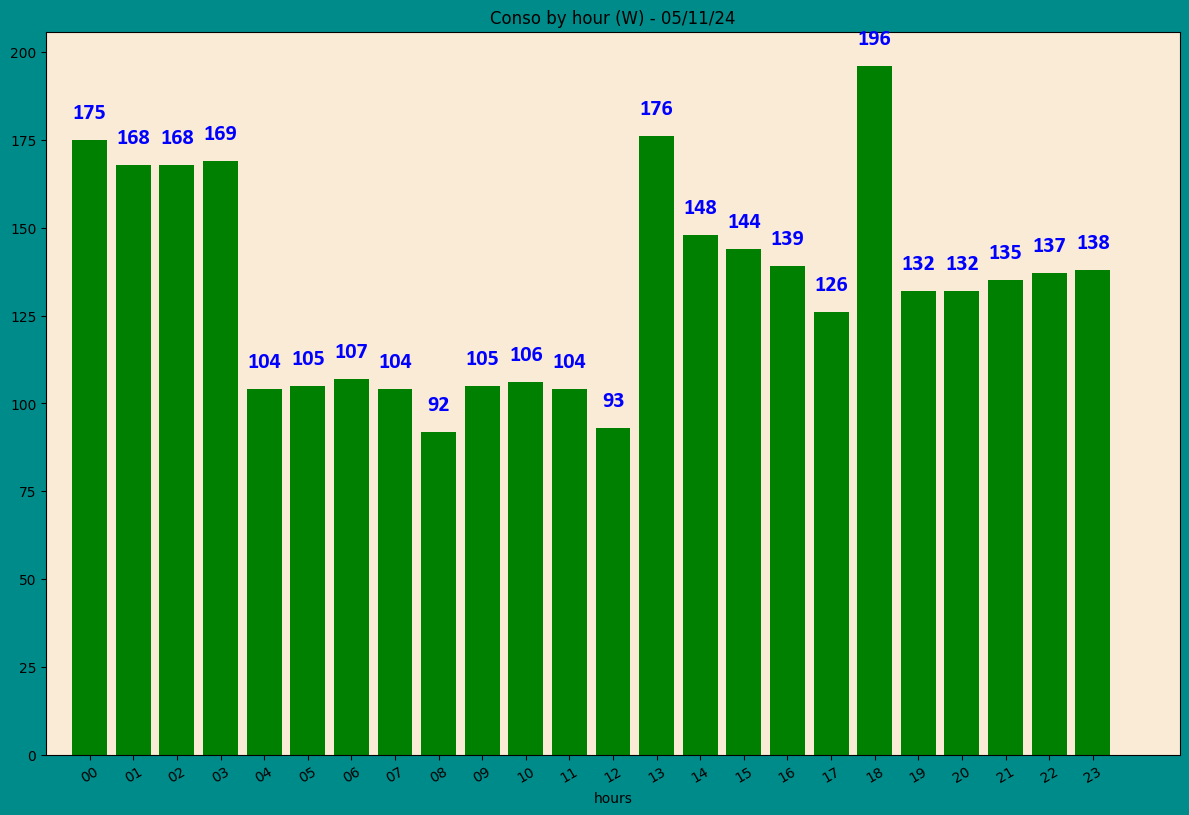

In [489]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [490]:
month

,day,hours,months,kWh
687104,01,00,2025-04,0.21
687105,01,00,2025-04,0.21
687106,01,00,2025-04,0.21
687107,01,00,2025-04,0.21
687108,01,00,2025-04,0.21
...,...,...,...,...
783100,30,23,2025-04,0.09
783101,30,23,2025-04,0.09
783102,30,23,2025-04,0.09
783103,30,23,2025-04,0.09


In [491]:
month.describe()


,kWh
count,96001.000000
mean,0.310191
std,0.547372
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

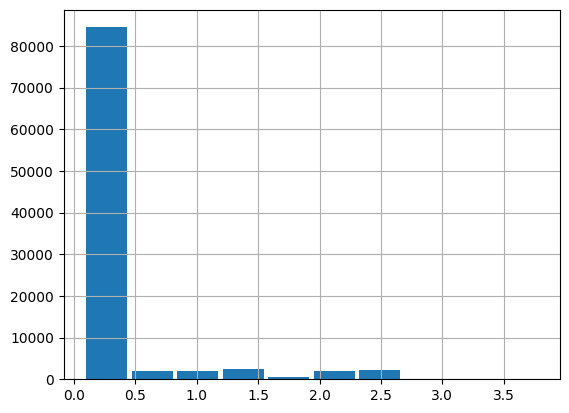

In [492]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

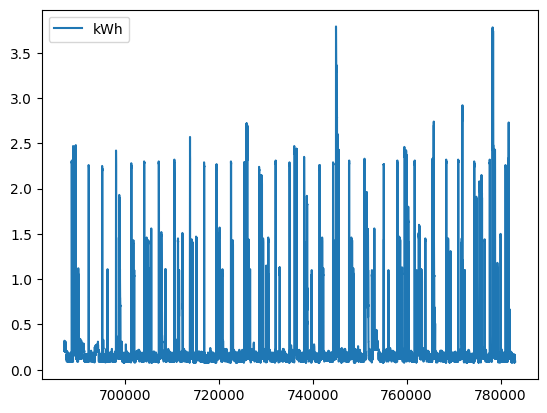

In [493]:
month.plot()

In [494]:
# index with max conso in this month
month.idxmax().kWh

np.int64(744957)

In [495]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       780205
hours     690646
months    687104
kWh       744957
dtype: int64

In [496]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [497]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
03/09/24 06      21      21    NaN   NaN
         07     127     148  106.0   NaN
         08     121     269   -6.0   NaN
         09     122     391    1.0   NaN
         10     122     513    0.0   NaN
...             ...     ...    ...   ...
13/07/25 17      96    2015  -11.0  18.0
         18      95    2110   -1.0  19.0
         19     102    2212    7.0  20.0
         20     100    2312   -2.0  21.0
         21      36    2348  -64.0  22.0

[7528 rows x 4 columns]

In [498]:
month

,day,hours,months,kWh
687104,01,00,2025-04,0.21
687105,01,00,2025-04,0.21
687106,01,00,2025-04,0.21
687107,01,00,2025-04,0.21
687108,01,00,2025-04,0.21
...,...,...,...,...
783100,30,23,2025-04,0.09
783101,30,23,2025-04,0.09
783102,30,23,2025-04,0.09
783103,30,23,2025-04,0.09


In [499]:
month.idxmax()


day       780205
hours     690646
months    687104
kWh       744957
dtype: int64

In [500]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 744957, dtype: object

In [501]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       178
          01       175
          02       171
          03       117
          04       114
          05       110
          06       110
          07        99
          08       111
          09       111
          10       109
          11        97
          12       171
          13       145
          14       148
          15       133
          16       202
          17       142
          18       153
          19       198
          20       145
          21       149
          22       140
          23       174
Name: kWh, dtype: int64

In [502]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

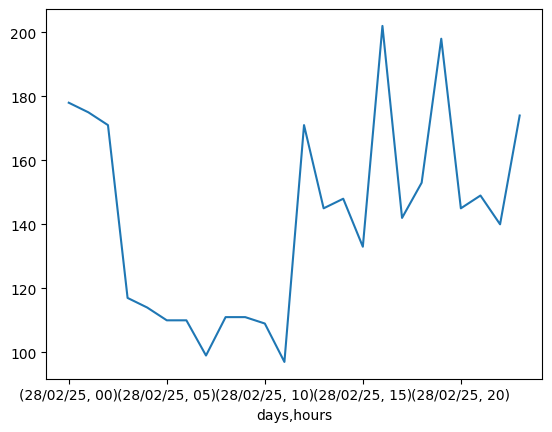

In [503]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [504]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [505]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [506]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [507]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB